<a href="https://colab.research.google.com/github/Volks44/VITMMA19/blob/main/Pretrained_RestNet50_V_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the dataset

In [1]:
!pip install np_utils --quiet
import keras
from keras.datasets import cifar10
import np_utils as np_utils
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential
import tensorflow as tf
!pip install -q wandb
import wandb
wandb.login(key="a8b8eb57a9fc053a10a60cc53823334a37b0849e")

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 787.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.8 MB/s eta 0:00:00


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


170498071/170498071 [==============================] - 2s 0us/step


In [2]:
# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_test= keras.utils.to_categorical(y_test, num_classes)

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


Image preprocesing

In [3]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [4]:
x_train = preprocess_image_input(x_train)
x_valid = preprocess_image_input(x_valid)

Define the model

In [5]:
def feature_extractor(inputs):
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

In [6]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

In [7]:
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

In [8]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

Train the model

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [10]:
# training
batch_size = 64
epochs= 100

wandb.init(project="Deep_Learning_Proj")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="my_model",verbose=1, monitor='val_accuracy',save_best_only=True), early_stopping
    ]

#checkpointer = WandbModelCheckpoint(filepath="my_model",verbose=1, monitor='val_accuracy',save_best_only=True)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (x_valid, y_valid),callbacks=[callbacks])

wandb.finish()

wandb: Currently logged in as: joseb493 (jb-bx7fn1). Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/100
  6/704 [..............................] - ETA: 6:59 - loss: 2.2951 - accuracy: 0.1927

704/704 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.8651
Epoch 1: val_accuracy improved from -inf to 0.86680, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 1.0s


704/704 [==============================] - 534s 699ms/step - loss: 0.4153 - accuracy: 0.8651 - val_loss: 0.3782 - val_accuracy: 0.8668
Epoch 2/100
704/704 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9656
Epoch 2: val_accuracy improved from 0.86680 to 0.90980, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 4.5s


704/704 [==============================] - 489s 694ms/step - loss: 0.1054 - accuracy: 0.9656 - val_loss: 0.2772 - val_accuracy: 0.9098
Epoch 3/100
704/704 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 0.9895
Epoch 3: val_accuracy did not improve from 0.90980


wandb: Adding directory to artifact (./my_model)... Done. 0.7s


704/704 [==============================] - 450s 639ms/step - loss: 0.0355 - accuracy: 0.9895 - val_loss: 0.3718 - val_accuracy: 0.8994
Epoch 4/100
704/704 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9960
Epoch 4: val_accuracy did not improve from 0.90980


wandb: Adding directory to artifact (./my_model)... Done. 0.9s


704/704 [==============================] - 457s 650ms/step - loss: 0.0162 - accuracy: 0.9960 - val_loss: 0.8364 - val_accuracy: 0.8256
Epoch 5/100
704/704 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9964
Epoch 5: val_accuracy improved from 0.90980 to 0.93060, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 0.9s


704/704 [==============================] - 484s 688ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.2647 - val_accuracy: 0.9306
Epoch 6/100
704/704 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9986
Epoch 6: val_accuracy improved from 0.93060 to 0.95720, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 4.6s


704/704 [==============================] - 482s 684ms/step - loss: 0.0070 - accuracy: 0.9986 - val_loss: 0.1612 - val_accuracy: 0.9572
Epoch 7/100
704/704 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9995
Epoch 7: val_accuracy did not improve from 0.95720


wandb: Adding directory to artifact (./my_model)... Done. 0.8s


704/704 [==============================] - 458s 650ms/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 0.1693 - val_accuracy: 0.9564
Epoch 8/100
704/704 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996
Epoch 8: val_accuracy improved from 0.95720 to 0.95880, saving model to my_model


wandb: Adding directory to artifact (./my_model)... Done. 4.7s


704/704 [==============================] - 484s 687ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.1632 - val_accuracy: 0.9588
Epoch 9/100
704/704 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9996
Epoch 9: val_accuracy did not improve from 0.95880


wandb: Adding directory to artifact (./my_model)... Done. 1.2s


704/704 [==============================] - 458s 651ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.1677 - val_accuracy: 0.9578
Epoch 10/100
704/704 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9997
Epoch 10: val_accuracy did not improve from 0.95880


wandb: Adding directory to artifact (./my_model)... Done. 0.7s


704/704 [==============================] - 458s 650ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.9319 - val_accuracy: 0.8632
Epoch 11/100
704/704 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9984
Epoch 11: val_accuracy did not improve from 0.95880


wandb: Adding directory to artifact (./my_model)... Done. 0.8s


704/704 [==============================] - 457s 650ms/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.6436 - val_accuracy: 0.8804


epoch/accuracy,▁▆▇████████
epoch/epoch,▁▂▂▃▄▅▅▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▁▁▁▁▁▁▁
epoch/val_accuracy,▃▅▅▁▇████▃▄
epoch/val_loss,▃▂▃▇▂▁▁▁▁█▅
epoch/accuracy,0.99844
epoch/epoch,10
epoch/learning_rate,0.01
epoch/loss,0.006
epoch/val_accuracy,0.8804


Evaluate the model

In [11]:
loss, accuracy = model.evaluate(x_valid, y_valid, batch_size=64)


79/79 [==============================] - 14s 171ms/step - loss: 0.1612 - accuracy: 0.9572




> Learning Curves



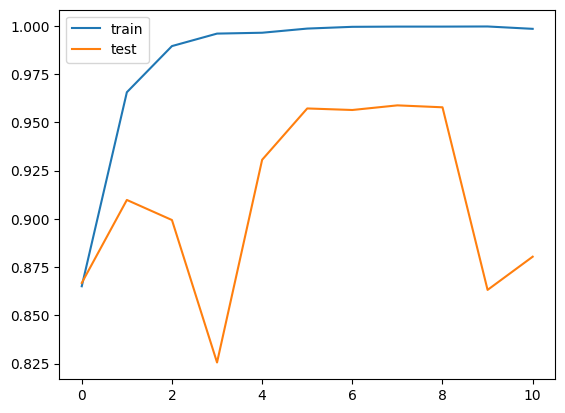

In [12]:
# plot learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()



> Visual Test



In [13]:
# get  on the test set
y_hat = model.predict(x_test)

# define text labels
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

313/313 [==============================] - 31s 91ms/step


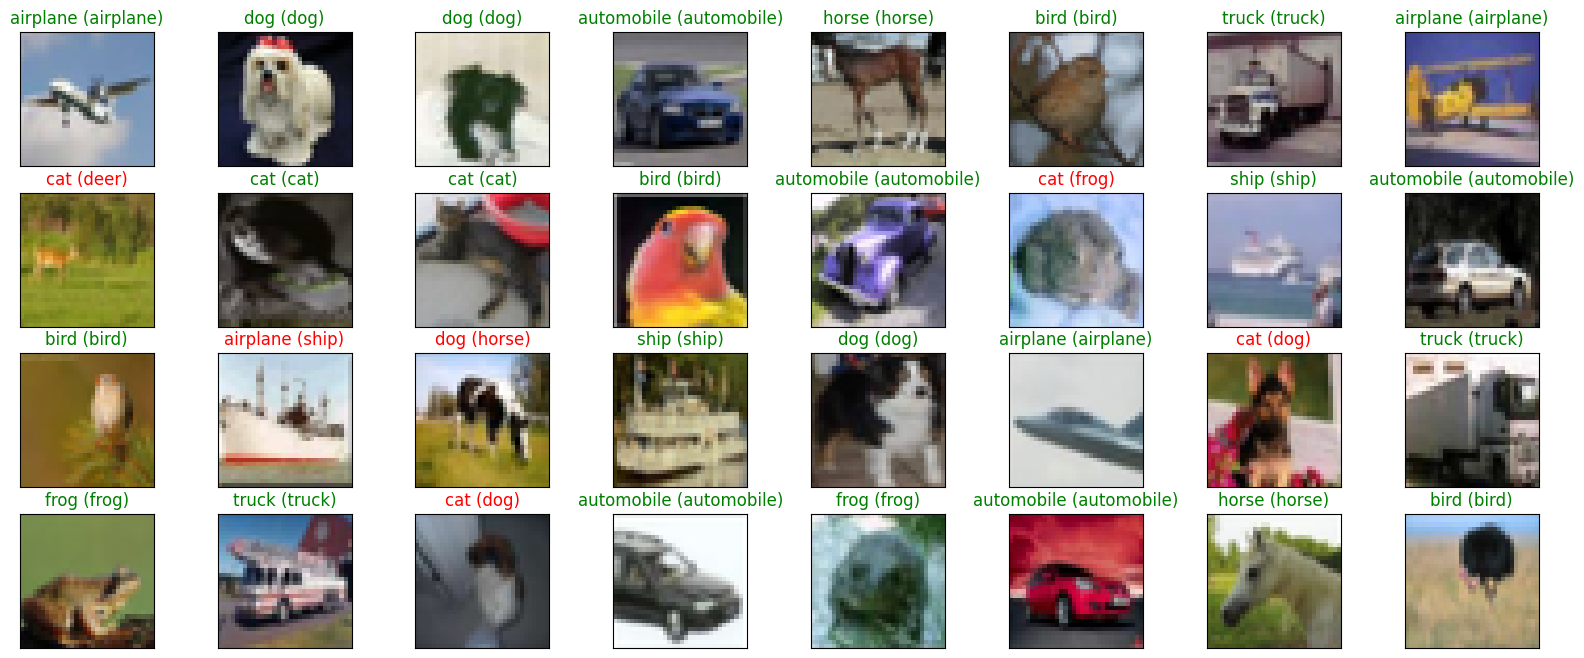

In [15]:
0# plot a random sample of test images, their predicted labels, and ground truth
fig = pyplot.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

> Confusion Matrix and Classification report

313/313 [==============================] - 28s 89ms/step


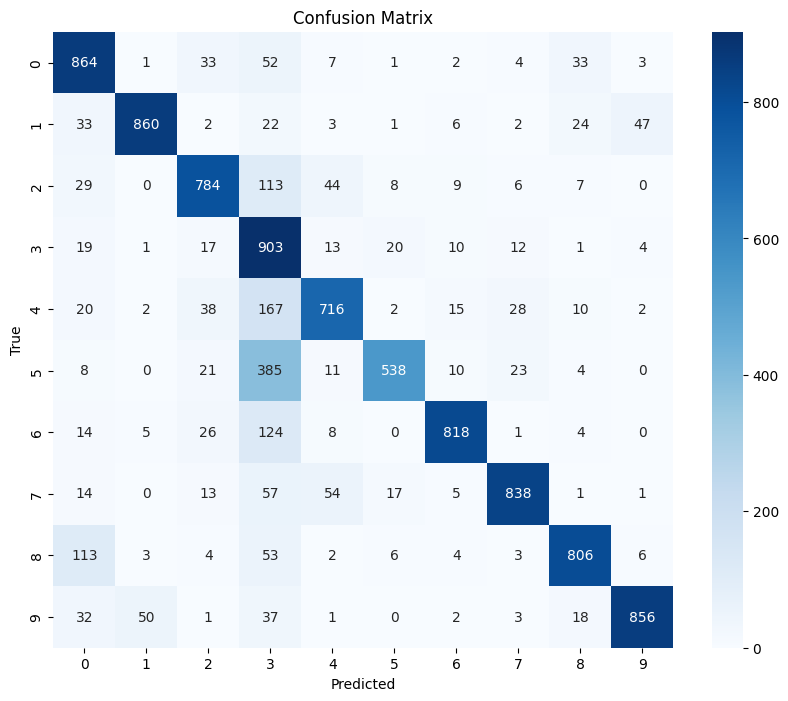


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.81      1000
           1       0.93      0.86      0.89      1000
           2       0.83      0.78      0.81      1000
           3       0.47      0.90      0.62      1000
           4       0.83      0.72      0.77      1000
           5       0.91      0.54      0.68      1000
           6       0.93      0.82      0.87      1000
           7       0.91      0.84      0.87      1000
           8       0.89      0.81      0.84      1000
           9       0.93      0.86      0.89      1000

    accuracy                           0.80     10000
   macro avg       0.84      0.80      0.81     10000
weighted avg       0.84      0.80      0.81     10000



In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Make predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Create confusion matrix
conf_matrix_clas = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
pyplot.figure(figsize=(10,8))
sns.heatmap(conf_matrix_clas, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.title('Confusion Matrix')
pyplot.show()

# Print classification report
class_report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(class_report)